In [110]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from itertools import cycle
import re

plt.rc("ytick.major", size=5, width=1)
plt.rcParams["text.usetex"] = False
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 22
plt.rcParams["axes.labelsize"] = 22

In [ ]:
#N,Blocks,Threads,Single-pass,Multi-pass
df = pd.read_csv("threadFenceReduction.csv")

#average runs with identical parameters N,Blocks,Threads
df = df.groupby(["N", "Blocks", "Threads"]).mean().reset_index()

C:\Users\domin\AppData\Local\Temp\ipykernel_20000\1668633032.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


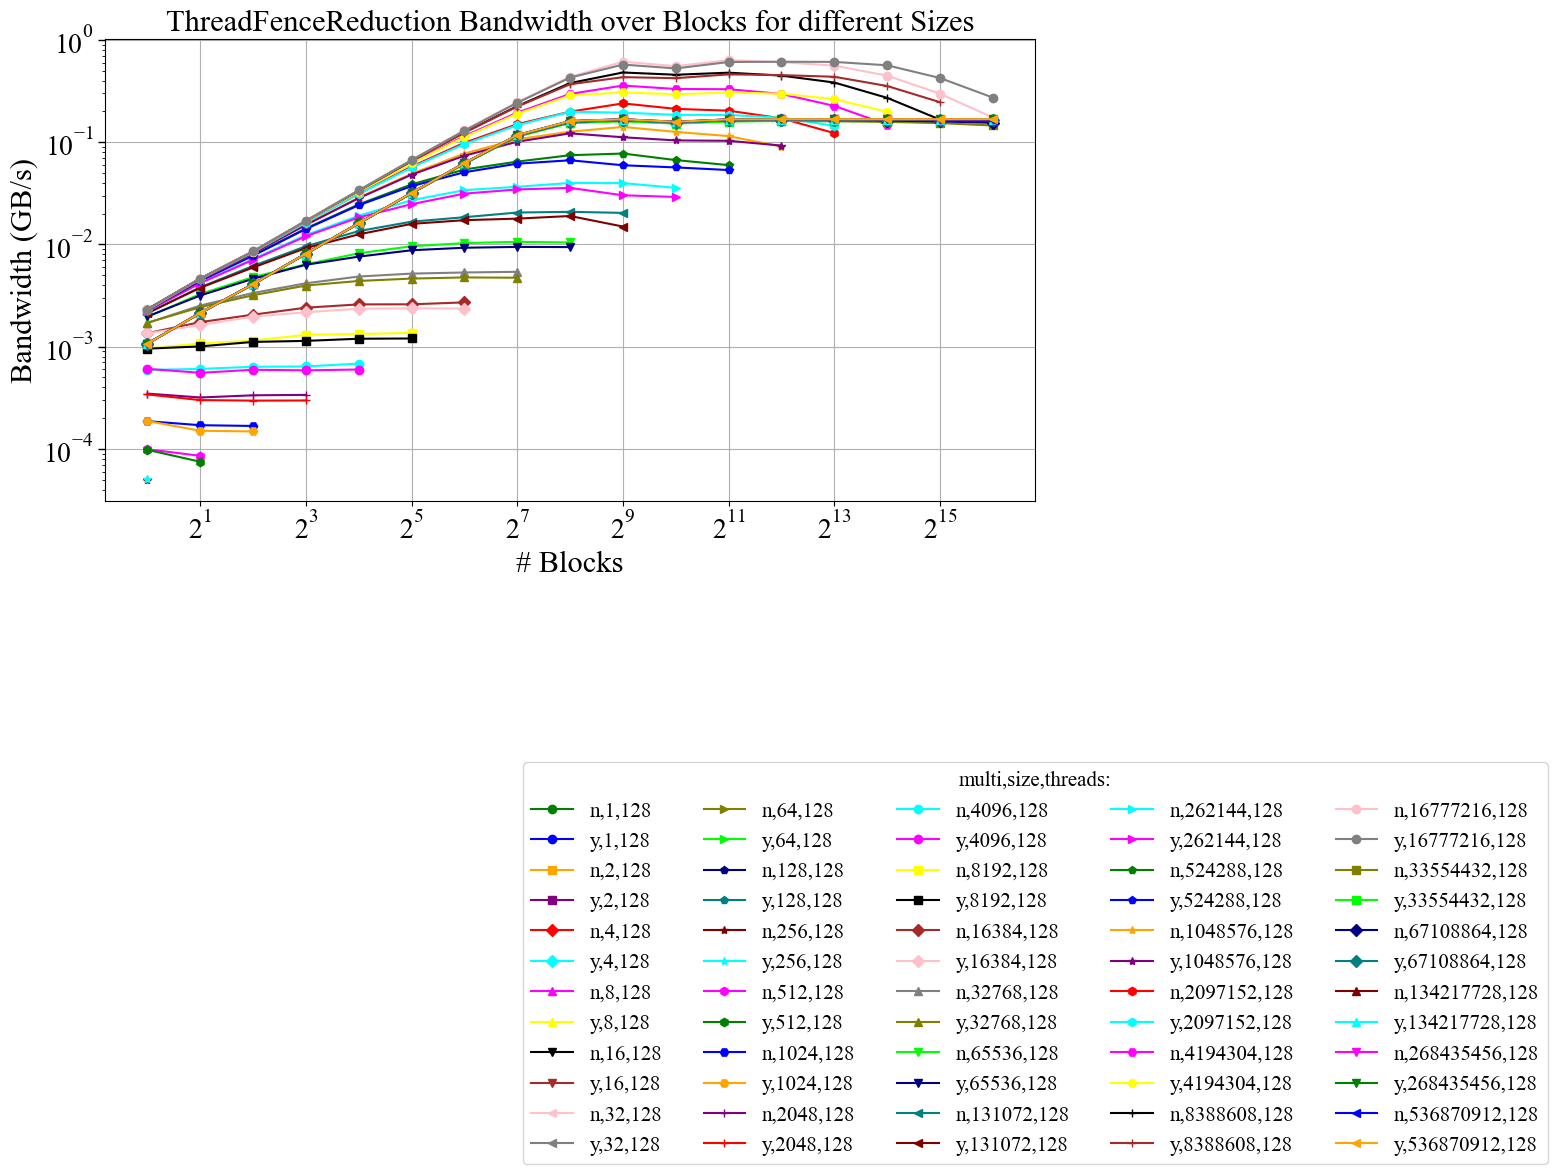

In [112]:
# Define colors and markers
colors = ['green', 'blue', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'aqua', 'fuchsia']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']

# Create cycles for colors and markers
color_cycle = cycle(colors)
marker_cycle = cycle(markers)

plt.figure(figsize=(12, 6))

# filter df by blocks size and threads
for size in df["N"].unique():
    marker = next(marker_cycle)
    # for threads in df["Threads"].unique():
    dff = df[(df["N"] == size) & (df["Threads"] == 128)]    
    color = next(color_cycle)
    plt.plot(dff["Blocks"],dff["SingleGB/s"], label=f"n,{size},{128}", color=color, marker=marker)
    color = next(color_cycle)
    plt.plot(dff["Blocks"],dff["MultiGB/s"], label=f"y,{size},{128}", color=color, marker=marker)

plt.xscale("log", base=2)
plt.yscale("log")
# plt.ylim(1e-4)
# plt.xlim(2**(0),2**29)
plt.xlabel("# Blocks")
plt.ylabel("Bandwidth (GB/s)")
plt.title("ThreadFenceReduction Bandwidth over Blocks for different Sizes")
plt.legend(title="multi,size,threads:", ncols=5, loc='center', bbox_to_anchor=(1, -1))
plt.grid(which="major")
plt.tight_layout()
plt.savefig("threadFenceReduction.pdf", bbox_inches="tight")
plt.show()

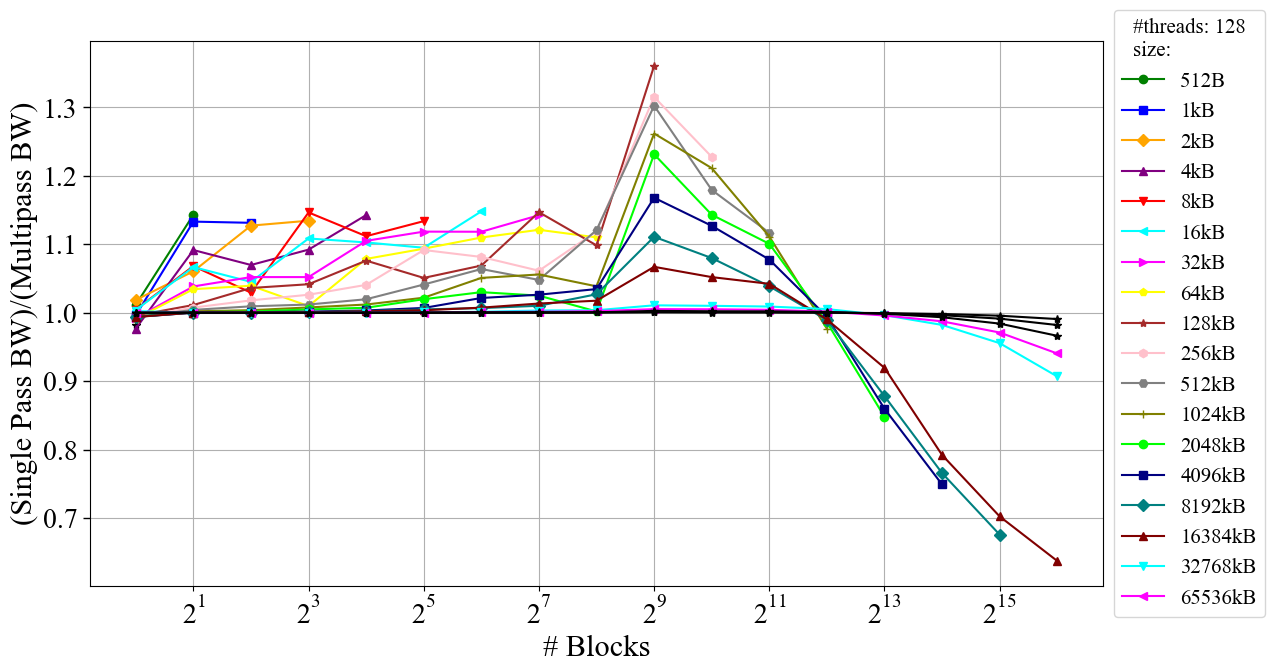

In [ ]:
# Define colors and markers
colors = ['green', 'blue', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'aqua', 'fuchsia']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']

# Create cycles for colors and markers
color_cycle = cycle(colors)
marker_cycle = cycle(markers)

plt.figure(figsize=(13, 7))

# filter df by blocks size and threads
for size in df["N"].unique():
    

    # for threads in df["Threads"].unique():
    dff = df[(df["N"] == size) & (df["Threads"] == 128)]     
    diff = dff["SingleGB/s"]/dff["MultiGB/s"]
    if (abs(diff).max()>1.05 or abs(diff).min()<0.95):
        color = next(color_cycle)
        marker = next(marker_cycle)
        if size < 1024:
            l= str(size)
        elif size < 1024**2:
            l= f"{size // 1024}k"
        elif size < 1024**3:
            l= f"{size // 1024**2}M"
        else:
            l= f"{size // 1024**3}G"
        plt.plot(dff["Blocks"],diff, label=l, color=color, marker=marker)
    else:
        color="black"
        marker="*"
        plt.plot(dff["Blocks"],diff, label=f"", color=color, marker=marker)

plt.xscale("log", base=2)
plt.xlabel("# Blocks")
plt.ylabel("(Single Pass BW)/(Multipass BW)")
# plt.title("ThreadFenceReduction Performance Comparison Single Pass vs. Multipass over\nBlocks of Different Sizes, with a Maximum Performance Difference > 5%", loc="left")
plt.legend(title="#threads: 128\nsize:", loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(which="major")
plt.tight_layout()
plt.savefig("threadFenceReduction.pdf", bbox_inches="tight")
plt.show()

In [ ]:
# get best performing # blocks for each size


# Define colors and markers
colors = ['green', 'blue', 'orange', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray', 'olive', 'lime', 'navy', 'teal', 'maroon', 'aqua', 'fuchsia']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'H', '+']

# Create cycles for colors and markers
color_cycle = cycle(colors)
marker_cycle = cycle(markers)

# filter df by blocks size and threads
best_blocks = []

for size in df["N"].unique():
    dff = df[(df["N"] == size)]
    best_block_single = dff.loc[dff["SingleGB/s"].idxmax()]
    best_block_multi = dff.loc[dff["MultiGB/s"].idxmax()]
    if best_block_single.max() > best_block_multi.max(): best_blocks.append(best_block_single)
    else: best_blocks.append(best_block_multi)

#remove data
# Create a DataFrame with the best performing blocks
best_blocks_df = pd.DataFrame(best_blocks)
table = best_blocks_df.to_latex(index=False)

with open("table.tex", "w") as f:
    f.write(table)